In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sashankvasireddy","key":"02fea341ece56e8cb7ce1306d6ca0636"}'}

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 36.9MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.8MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

## Importing libraries for reading data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
color = sns.color_palette()
%matplotlib inline
import glob
import os

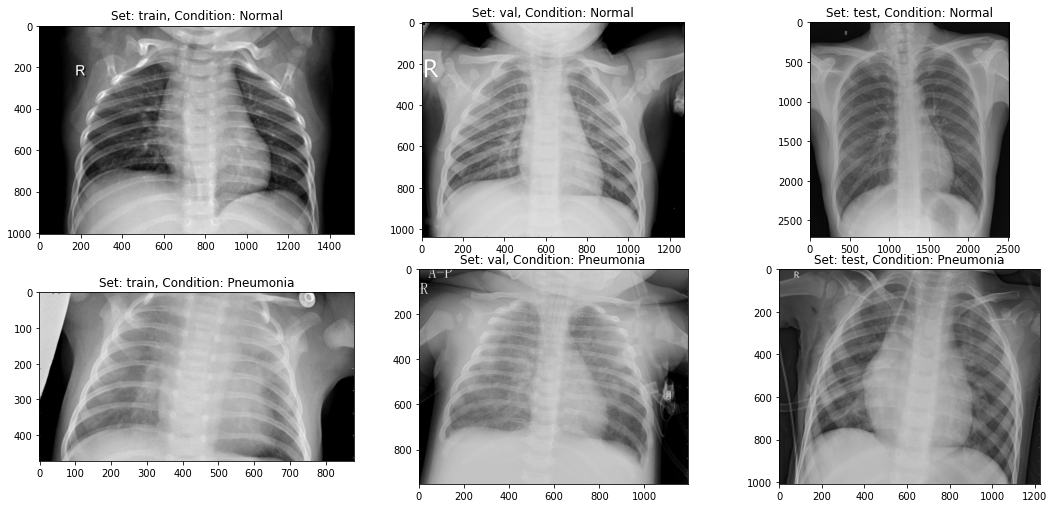

In [ ]:
input_path='/content/chest_xray/chest_xray/'
fig,ax=plt.subplots(2,3,figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [ ]:
for _set in ['train','val','test']:
  n_normal=len(os.listdir(input_path+_set+'/NORMAL'))
  n_infect=len(os.listdir(input_path+_set+'/PNEUMONIA'))
  print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


## Data Augementation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims=150
batch_size=32
epochs=10

In [ ]:
train_gen,test_gen,test_data,test_labels=process_data(img_dims,batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building 

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
model=Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu',input_shape=(img_dims,img_dims,3)))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       7

In [ ]:
#CallBacks

checkpoint=ModelCheckpoint(filepath='best_weights.hdf5',save_best_only=True,save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=2,verbose=2,mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 103s 444ms/step - loss: 0.6287 - accuracy: 0.7487 - val_loss: 0.7844 - val_accuracy: 0.7007
Epoch 2/10
163/163 [==============================] - 72s 440ms/step - loss: 0.3424 - accuracy: 0.8476 - val_loss: 0.4617 - val_accuracy: 0.8273
Epoch 3/10
163/163 [==============================] - 72s 439ms/step - loss: 0.2944 - accuracy: 0.8683 - val_loss: 0.4410 - val_accuracy: 0.8865

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 72s 439ms/step - loss: 0.2143 - accuracy: 0.9085 - val_loss: 0.4631 - val_accuracy: 0.8997
Epoch 5/10
163/163 [==============================] - 71s 438ms/step - loss: 0.1796 - accuracy: 0.9284 - val_loss: 0.4227 - val_accuracy: 0.9046

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 71s 438ms/step - loss: 0.1477 - accuracy: 0.9469 - val_los

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape=(img_dims,img_dims,3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.1))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [ ]:
hist1=model1.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 74s 448ms/step - loss: 1.4554 - accuracy: 0.7961 - val_loss: 22.0046 - val_accuracy: 0.6266
Epoch 2/10
163/163 [==============================] - 74s 453ms/step - loss: 0.2720 - accuracy: 0.8882 - val_loss: 25.0285 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 72s 444ms/step - loss: 0.2458 - accuracy: 0.9047 - val_loss: 0.5422 - val_accuracy: 0.8240
Epoch 4/10
163/163 [==============================] - 73s 447ms/step - loss: 0.2146 - accuracy: 0.9228 - val_loss: 8.2778 - val_accuracy: 0.6250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
163/163 [==============================] - 73s 447ms/step - loss: 0.1642 - accuracy: 0.9396 - val_loss: 3.6752 - val_accuracy: 0.6628
Epoch 6/10
163/163 [==============================] - 73s 445ms/step - loss: 0.1309 - accuracy: 0.9516 - val_loss: 17.9311 - val_accuracy: 0.6250

Epoch 00006: ReduceLROnPlateau reducing learn

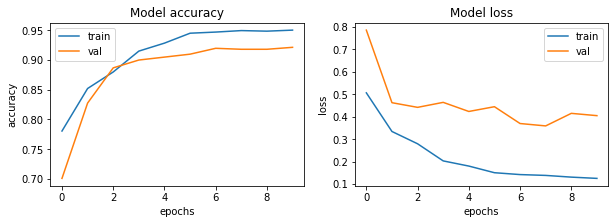

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist1.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[190  44]
 [  4 386]]

TEST METRICS ----------------------
Accuracy: 92.3076923076923%
Precision: 89.76744186046511%
Recall: 98.97435897435898%
F1-score: 94.14634146341463

TRAIN METRIC ----------------------
Train acc: 96.47


In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model2 = Model(inputs=inputs, outputs=output)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
hist2=model2.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 77s 465ms/step - loss: 0.4392 - accuracy: 0.7820 - val_loss: 0.7937 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 75s 459ms/step - loss: 0.2788 - accuracy: 0.8726 - val_loss: 0.6834 - val_accuracy: 0.6266
Epoch 3/10
163/163 [==============================] - 75s 459ms/step - loss: 0.3337 - accuracy: 0.8569 - val_loss: 0.8889 - val_accuracy: 0.6234
Epoch 4/10
163/163 [==============================] - 74s 457ms/step - loss: 0.2755 - accuracy: 0.8899 - val_loss: 0.5801 - val_accuracy: 0.7944
Epoch 5/10
163/163 [==============================] - 74s 457ms/step - loss: 0.2734 - accuracy: 0.8861 - val_loss: 2.0065 - val_accuracy: 0.3701
Epoch 6/10
163/163 [==============================] - 74s 457ms/step - loss: 0.2631 - accuracy: 0.8966 - val_loss: 1.5629 - val_accuracy: 0.3750
Epoch 7/10
163/163 [==============================] - 74s 457ms/step - loss: 0.2223 - accuracy: 0.9146 - val_loss: 1.8711 - val_ac

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model2.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist2.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[175  59]
 [ 12 378]]

TEST METRICS ----------------------
Accuracy: 88.62179487179486%
Precision: 86.49885583524028%
Recall: 96.92307692307692%
F1-score: 91.41475211608223

TRAIN METRIC ----------------------
Train acc: 93.21


#Transfer Learning

### VGG-16 From Scratch

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
Num_classes=2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=x)

model3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [ ]:
for layer in model3.layers[0:20]:
    layer.trainable = False

In [ ]:
model3.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [ ]:
hist3=model3.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 75s 447ms/step - loss: 0.3977 - accuracy: 0.8247 - val_loss: 0.3214 - val_accuracy: 0.8684
Epoch 2/10
163/163 [==============================] - 73s 446ms/step - loss: 0.1961 - accuracy: 0.9238 - val_loss: 0.3058 - val_accuracy: 0.8865
Epoch 3/10
163/163 [==============================] - 72s 444ms/step - loss: 0.1656 - accuracy: 0.9333 - val_loss: 0.3162 - val_accuracy: 0.8832

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/10
163/163 [==============================] - 72s 444ms/step - loss: 0.1628 - accuracy: 0.9366 - val_loss: 0.2786 - val_accuracy: 0.8882
Epoch 5/10
163/163 [==============================] - 72s 445ms/step - loss: 0.1608 - accuracy: 0.9407 - val_loss: 0.2975 - val_accuracy: 0.8849

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 6/10
163/163 [==============================] - 72s 444ms/step - loss: 0.1437 - accuracy: 0.9485 - val_lo

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model3.predict(test_data)

acc3 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc3))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist3.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[176  58]
 [ 12 378]]

TEST METRICS ----------------------
Accuracy: 88.78205128205127%
Precision: 86.69724770642202%
Recall: 96.92307692307692%
F1-score: 91.52542372881356

TRAIN METRIC ----------------------
Train acc: 94.63


In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
Num_classes=2
base_model1 = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=base_model.input, outputs=x)

model4.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

In [ ]:
for layer in model4.layers[0:20]:
    layer.trainable = False

In [ ]:
model4.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

In [ ]:
hist4=model4.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 74s 451ms/step - loss: 0.3575 - accuracy: 0.8294 - val_loss: 0.2860 - val_accuracy: 0.8914
Epoch 2/10
163/163 [==============================] - 72s 445ms/step - loss: 0.1968 - accuracy: 0.9200 - val_loss: 0.2588 - val_accuracy: 0.8898
Epoch 3/10
163/163 [==============================] - 73s 445ms/step - loss: 0.1677 - accuracy: 0.9354 - val_loss: 0.2917 - val_accuracy: 0.8865
Epoch 4/10
163/163 [==============================] - 73s 446ms/step - loss: 0.1592 - accuracy: 0.9383 - val_loss: 0.2521 - val_accuracy: 0.8964
Epoch 5/10
163/163 [==============================] - 73s 445ms/step - loss: 0.1488 - accuracy: 0.9424 - val_loss: 0.2331 - val_accuracy: 0.9079

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
163/163 [==============================] - 73s 446ms/step - loss: 0.1488 - accuracy: 0.9413 - val_loss: 0.2608 - val_accuracy: 0.8980
Epoch 7/10
163/163 [============================

In [ ]:
preds = model4.predict(test_data)

acc4 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist4.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[179  55]
 [ 11 379]]

TEST METRICS ----------------------
Accuracy: 88.62179487179486%
Precision: 87.32718894009217%
Recall: 97.17948717948718%
F1-score: 91.99029126213593

TRAIN METRIC ----------------------
Train acc: 95.15


## RESNET

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
output=restnet.layers[-1].output

output = keras.layers.Flatten()(output)

restnet = Model(restnet.input,outputs=output)
for layer in restnet.layers[0:20]:
    layer.trainable = False
restnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model5 = Sequential()
model5.add(restnet)
model5.add(Dense(256, activation='relu', input_dim=(150,150,3)))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 51200)             23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 36,728,193
Trainable params: 36,573,377
Non-trainable params: 154,816
_________________________________________________________________


In [ ]:
hist5=model5.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 82s 470ms/step - loss: 1.0135 - accuracy: 0.7870 - val_loss: 13778.3994 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 76s 466ms/step - loss: 0.2964 - accuracy: 0.8718 - val_loss: 2728.1030 - val_accuracy: 0.6201
Epoch 3/10
163/163 [==============================] - 76s 464ms/step - loss: 0.2639 - accuracy: 0.8816 - val_loss: 0.3792 - val_accuracy: 0.8289

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/10
163/163 [==============================] - 76s 464ms/step - loss: 0.2273 - accuracy: 0.9072 - val_loss: 0.5767 - val_accuracy: 0.6349
Epoch 5/10
163/163 [==============================] - 76s 464ms/step - loss: 0.1731 - accuracy: 0.9349 - val_loss: 0.6912 - val_accuracy: 0.7928

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 6/10
163/163 [==============================] - 76s 465ms/step - loss: 0.1557 - accuracy: 0.9411 -

In [ ]:
preds = model5.predict(test_data)

acc5 = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist5.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[172  62]
 [ 14 376]]

TEST METRICS ----------------------
Accuracy: 88.62179487179486%
Precision: 85.84474885844749%
Recall: 96.41025641025641%
F1-score: 90.82125603864733

TRAIN METRIC ----------------------
Train acc: 95.19


In [ ]:
train_accuracy=[]

for his in [hist1,hist2,hist3,hist4,hist5]:

  X=his.history.get('accuracy')[-1] 
  train_accuracy.append(X)

In [ ]:
train_accuracy

[0.9647239446640015,
 0.9321318864822388,
 0.946319043636322,
 0.9514954090118408,
 0.9518788456916809]